In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# use GPU for computations if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# temporarily patch this script until the MNIST data set download issue is resolved
# https://github.com/pytorch/vision/issues/1938
import urllib.request
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Classification of hand-written digits

We start by downloading and extracting the MNIST data set.

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transforms.ToTensor())

# extract a complete PyTorch dataset
def extract(dataset):
    datasize = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=datasize, shuffle=False)
    return next(iter(dataloader))

# extract all test images and labels into PyTorch tensors
# the training data will be loaded in batches during training
test_X, test_Y = extract(testset)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.44MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 159kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.78MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## The model

The input data $X$ are grayscale images of $28\times 28$ pixels. The first dimension will be the number of data points that are provided to the network. The input data is flattend into a matrix with $28 \times 28 = 784$ columns using `X.view(-1, 784)`, where each colum represents one pixel. We then apply first the linear transformation $X W + b$ and then the softmax function to obtain the class probabilities predicted by the model.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # the weights of dimension (784, 10)
        self.W = nn.Parameter(torch.zeros(784, 10))
        # the offset vector of dimension (10,)
        self.b = nn.Parameter(torch.zeros(10))

    def forward(self, X):
        # flatten the data into a matrix with 28 x 28 = 784 columns
        X = X.view(-1, 784)
        # compute the linear transformation
        Z = X.mm(self.W) + self.b
        # apply the softmax function
        G = F.softmax(Z, dim=1)
        return G

## The training

We define the cross-entropy for the predicted probabilities $G$ (10-dimensional vectors) and the labels $Y$ (integers between 0 and 9).

In [4]:
def crossentropy(G, Y):
    # convert labels to onehot encoding
    Y_onehot = torch.eye(10, device=device)[Y]
    return -(Y_onehot * G.log()).sum(dim = 1).mean()


The next lines evaluate the accuracy of the predictions.

In [5]:
def accuracy(G, Y):
    return (G.argmax(dim=1) == Y).float().mean()

We are ready to train the network.

In [6]:
# initialize the test and training error statistics
test_accuracy = []
test_crossentropy = []
test_iter = []
train_accuracy = []
train_crossentropy = []
train_iter = []

# initialize the neural network and move it to the GPU if needed
net = Net()
net.to(device)

# define the optimization algorithm
learningrate = 0.5
optimizer = optim.SGD(net.parameters(), lr=learningrate)

# define the data loader for batches of the training data
batchsize = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)

# perform multiple training steps
total_iterations = 2000 # total number of iterations
t = 0 # current iteration
done = False
while not done:
    for (batch_X, batch_Y) in trainloader:
        # move batch to the GPU if needed
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        batch_G = net(batch_X)
        loss = crossentropy(batch_G, batch_Y)

        # backpropagation
        loss.backward()

        # perform gradient descent step
        optimizer.step()

        # don't bother too much about the following lines!
        with torch.no_grad():
            # evaluate the performance on the training data at every 10th iteration
            if t % 10 == 0:
                train_crossentropy.append(loss.item())
                train_accuracy.append(accuracy(batch_G, batch_Y).item())
                train_iter.append(t)

            # evaluate the performance on the test data at every 100th iteration
            if t % 100 == 0:
                # move test data to the GPU if needed
                X, Y = test_X.to(device), test_Y.to(device)

                # compute predictions for the test data
                G = net(X)
                test_crossentropy.append(crossentropy(G, Y).item())
                test_accuracy.append(accuracy(G, Y).item())
                test_iter.append(t)

                # print the iteration number and the accuracy of the predictions
                print(f"Step {t:5d}: train accuracy {100 * train_accuracy[-1]:6.2f}% " \
                      f"train cross-entropy {train_crossentropy[-1]:5.2f}  " \
                      f"test accuracy {100 * test_accuracy[-1]:6.2f}% " \
                      f"test cross-entropy {test_crossentropy[-1]:5.2f}")

        # stop the training after the specified number of iterations
        t += 1
        if t > total_iterations:
            done = True
            break

Step     0: train accuracy   8.00% train cross-entropy  2.30  test accuracy  28.45% test cross-entropy  2.02
Step   100: train accuracy  90.00% train cross-entropy  0.39  test accuracy  89.55% test cross-entropy  0.39
Step   200: train accuracy  95.00% train cross-entropy  0.24  test accuracy  90.29% test cross-entropy  0.34
Step   300: train accuracy  90.00% train cross-entropy  0.38  test accuracy  91.11% test cross-entropy  0.32
Step   400: train accuracy  86.00% train cross-entropy  0.56  test accuracy  90.61% test cross-entropy  0.33
Step   500: train accuracy  94.00% train cross-entropy  0.29  test accuracy  91.37% test cross-entropy  0.31
Step   600: train accuracy  92.00% train cross-entropy  0.26  test accuracy  91.00% test cross-entropy  0.31
Step   700: train accuracy  96.00% train cross-entropy  0.19  test accuracy  91.95% test cross-entropy  0.29
Step   800: train accuracy  90.00% train cross-entropy  0.25  test accuracy  91.76% test cross-entropy  0.30
Step   900: train a

## The evaluation

The remaining code produces the plots needed to evaluate the training and predictions.

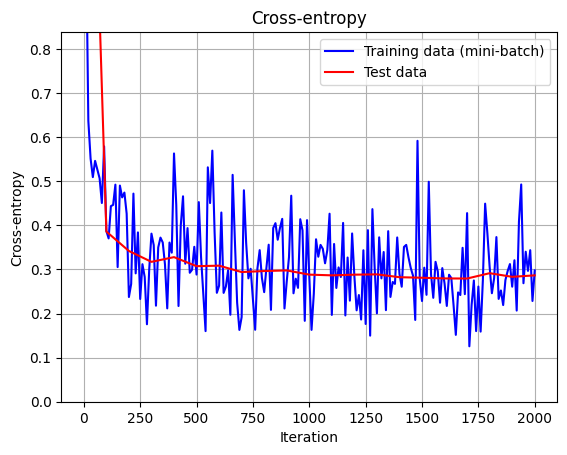

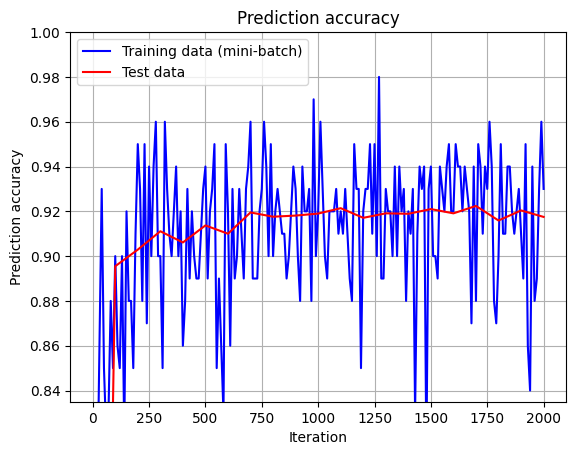

In [7]:
# plot the cross-entropy
plt.plot(train_iter, train_crossentropy, 'b-', label='Training data (mini-batch)')
plt.plot(test_iter, test_crossentropy, 'r-', label='Test data')
plt.xlabel('Iteration')
plt.ylabel('Cross-entropy')
plt.ylim([0, min(test_crossentropy) * 3])
plt.title('Cross-entropy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

# plot the accuracy
plt.plot(train_iter, train_accuracy, 'b-', label='Training data (mini-batch)')
plt.plot(test_iter, test_accuracy, 'r-', label='Test data')
plt.xlabel('Iteration')
plt.ylabel('Prediction accuracy')
plt.ylim([max(1 - (1 - test_accuracy[-1]) * 2, 0), 1])
plt.title('Prediction accuracy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

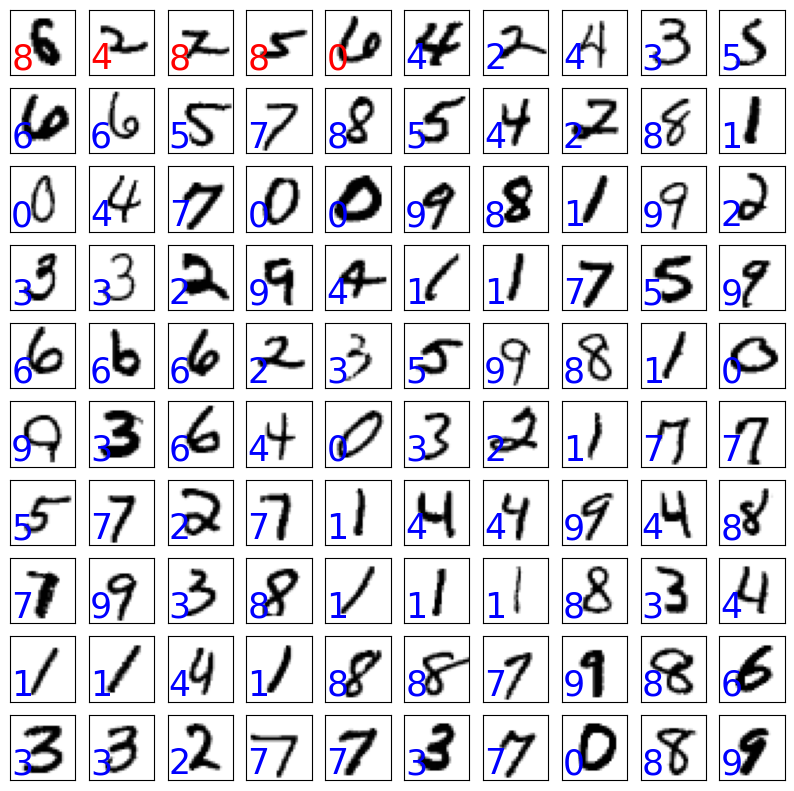

In [8]:
# evaluate the network on 100 random test images
with torch.no_grad():
    # obtain 100 random samples from the test data set
    random_X, random_Y = next(iter(torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)))

    # move data to the GPU if needed
    random_X, random_Y = random_X.to(device), random_Y.to(device)

    # compute the predictions for the sampled inputs
    random_G = net(random_X)
    random_Yhat = random_G.argmax(dim=1)

    # sort the predictions with the incorrect ones first
    indices_incorrect_first = (random_Yhat == random_Y).float().argsort()

# plot the images
num_rows = 10
num_cols = 10
num_images = num_rows * num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, index in enumerate(indices_incorrect_first, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])

    # plot the image
    plt.imshow(random_X[index, :, :].view(28, 28).cpu().numpy(), cmap=plt.cm.binary)

    # add the prediction as annotation (incorrect predictions in red, correct ones in blue)
    color = 'blue' if random_Yhat[index] == random_Y[index] else 'red'
    plt.text(0, 25, random_Yhat[index].item(), fontsize=25, color=color)

plt.show()